<a href="https://colab.research.google.com/github/Dubaifinest/Dubaifinest/blob/main/Seoul_Bike_Sharing_Demand_Data_Set_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

# Data Set
Currently Rental bikes are introduced in many urban cities for the enhancement of mobility comfort. It is important to make the rental bike available and accessible to the public at the right time as it lessens the waiting time. Eventually, providing the city with a stable supply of rental bikes becomes a major concern. The crucial part is the prediction of bike count required at each hour for the stable supply of rental bikes.
The dataset contains weather information (Temperature, Humidity, Windspeed, Visibility, Dewpoint, Solar radiation, Snowfall, Rainfall), the number of bikes rented per hour and date information.

https://archive.ics.uci.edu/ml/datasets/Seoul+Bike+Sharing+Demand

Data Source :http://data.seoul.go.kr/
SOUTH KOREA PUBLIC HOLIDAYS. URL: publicholidays.go.kr

In [4]:
dataset_cols = ["bike_count", "hour", "temp", "humidity", "wind", "visibility", "dew_pt_temp", "radiation", "rain", "snow", "functional"]
df = pd.read_csv("SeoulBikeData.csv", encoding= 'unicode_escape').drop(["Date", "Holiday", "Seasons"], axis=1)

In [7]:
df.columns = dataset_cols
df["functional"] = (df["functional"] == "yes").astype(int)
df=df[df["hour"] == 12]
df = df.drop(["hour"], axis = 1)

In [8]:
df.head()

,bike_count,temp,humidity,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,0
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,0
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,0
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,0
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,0


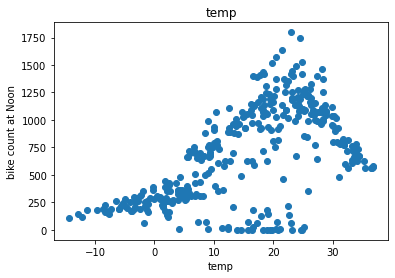

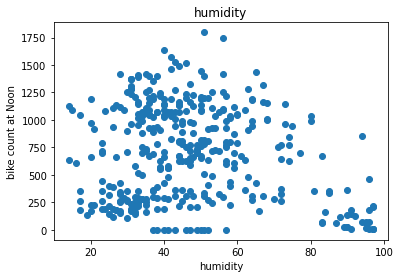

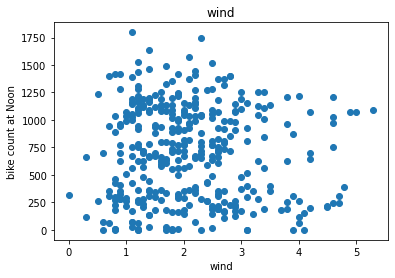

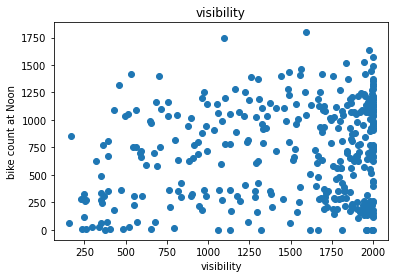

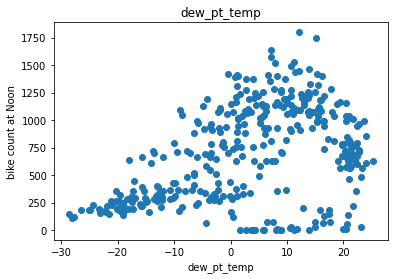

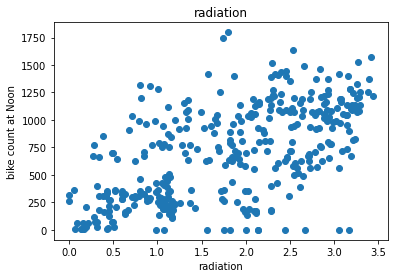

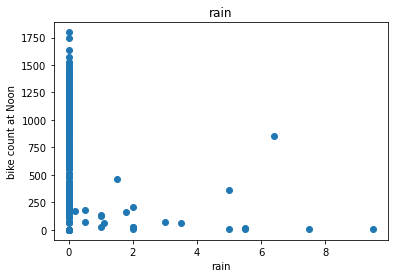

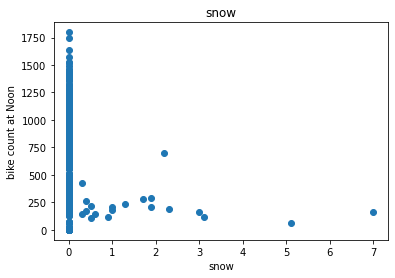

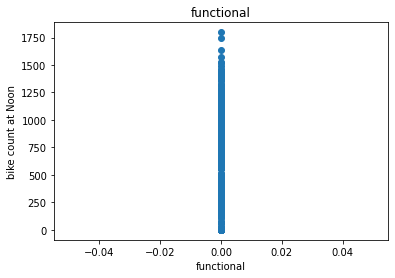

In [9]:
for label in df.columns[1:]:
  plt.scatter(df[label], df["bike_count"])
  plt.title(label)
  plt.ylabel("bike count at Noon")
  plt.xlabel(label)
  plt.show()


In [10]:
df = df.drop(["wind", "visibility", "functional"], axis = 1)

In [11]:
df.head()

,bike_count,temp,humidity,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Split the Data 

## Training / Validation / Test dataset

In [28]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])

In [29]:
def get_xy(dataframe, y_label, x_labels=None):
  dataframe = copy.deepcopy(dataframe)
  if x_labels is None:
    x = dataframe[[c for c in dataframe.columns if c!=y_label]].values
  else:
      if len(x_labels) == 1:
        x = dataframe[x_labels[0]].values.reshape(-1, 1)
      else:
        x = dataframe[x_labels].values

  y = dataframe[y_label].values.reshape(-1, 1)
  data = np.hstack((x, y))

  return data, x, y

In [30]:
_, x_train_temp, y_train_temp = get_xy(train, "bike_count", x_labels=["temp"])
_, x_val_temp, y_val_temp = get_xy(val, "bike_count", x_labels=["temp"])
_, x_test_temp, y_test_temp = get_xy(test, "bike_count", x_labels=["temp"])

In [31]:
temp_reg = LinearRegression()
temp_reg.fit(x_train_temp, y_train_temp)

LinearRegression()

In [32]:
print(temp_reg.coef_, temp_reg.intercept_)

[[19.99379736]] [391.44611844]


In [33]:
temp_reg.score(x_test_temp, y_test_temp)

0.3581245461067806

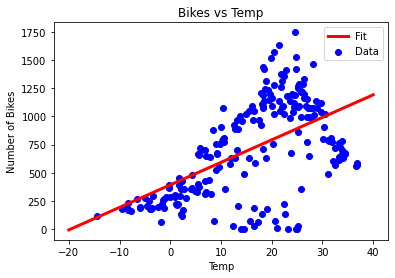

In [34]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_reg.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()


# Multiple Linear Regression

In [35]:
train, val, test = np.split(df.sample(frac=1), [int(0.6*len(df)), int(0.8*len(df))])
_, x_train_all, y_train_all = get_xy(train, "bike_count", x_labels=df.columns[1:])
_, x_val_all, y_val_all = get_xy(val, "bike_count", x_labels=df.columns[1:])
_, x_test_all, y_test_all = get_xy(test, "bike_count", x_labels=df.columns[1:])

In [36]:
all_reg = LinearRegression()
all_reg.fit(x_train_all, y_train_all)

LinearRegression()

In [37]:
all_reg.score(x_test_all, y_test_all)

0.4817735316526247

# Regression with Neural Net

In [42]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('MSE')
  plt.legend()
  plt.grid(True)
  plt.show()



In [43]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

In [44]:
temp_nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [45]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1), loss='mean_squared_error')

In [46]:
history = temp_nn_model.fit(
    x_train_temp.reshape(-1), y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(x_val_temp, y_val_temp)
)

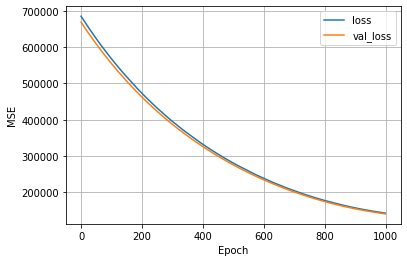

In [47]:
plot_loss(history)

4/4 [==============================] - 0s 4ms/step


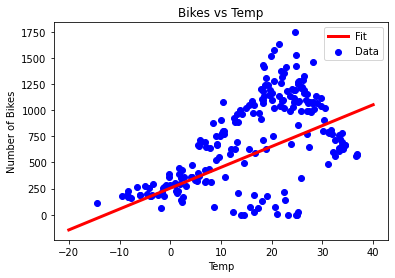

In [48]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, temp_nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

# Neural Net

In [56]:
temp_normalizer = tf.keras.layers.Normalization(input_shape=(1,), axis=None)
temp_normalizer.adapt(x_train_temp.reshape(-1))

nn_model = tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [57]:
history = nn_model.fit(
    x_train_temp, y_train_temp,
    validation_data=(x_val_temp, y_val_temp),
    verbose=0,
    epochs=100,
)

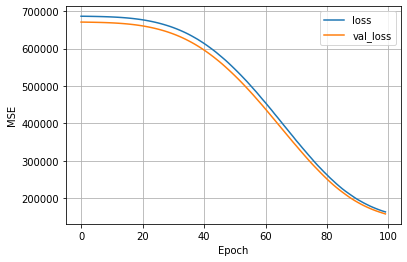

In [54]:
plot_loss(history)

4/4 [==============================] - 0s 5ms/step


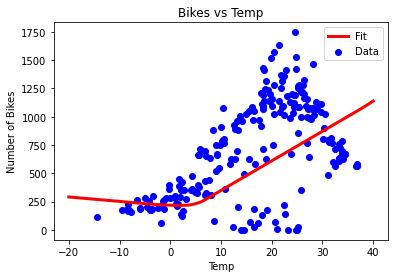

In [55]:
plt.scatter(x_train_temp, y_train_temp, label="Data", color="blue")
x = tf.linspace(-20, 40, 100)
plt.plot(x, nn_model.predict(np.array(x).reshape(-1, 1)), label="Fit", color="red", linewidth=3)
plt.legend()
plt.title("Bikes vs Temp")
plt.ylabel("Number of Bikes")
plt.xlabel("Temp")
plt.show()

In [66]:
all_normalizer = tf.keras.layers.Normalization(input_shape=(6,), axis=-1)
all_normalizer.adapt(x_train_all)


In [67]:
nn_model = tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1)
])

nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')

In [68]:
history = nn_model.fit(
    x_train_all, y_train_all,
    validation_data=(x_val_all, y_val_all),
    verbose=0,
    epochs=100,
)

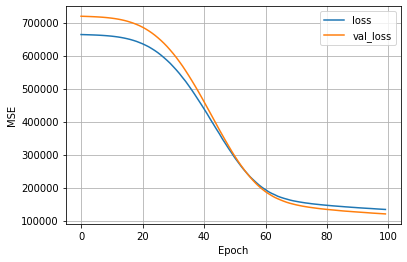

In [69]:
plot_loss(history)

## calculate the MSE for both linear reg and Neural Network

In [70]:
y_pred_lr = all_reg.predict(x_test_all)
y_pred_nn = nn_model.predict(x_test_all)

3/3 [==============================] - 0s 2ms/step


In [71]:
def MSE(y_pred, y_real):
  return (np.square(y_pred - y_real)).mean()


In [72]:
MSE(y_pred_lr, y_test_all)

94163.23269645654

In [73]:
MSE(y_pred_nn, y_test_all)

120961.11188028706

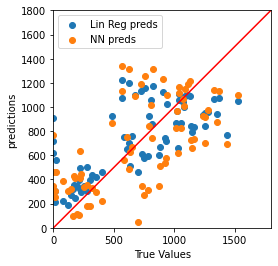

In [77]:
ax = plt.axes(aspect="equal")
plt.scatter(y_test_all, y_pred_lr, label="Lin Reg preds")
plt.scatter(y_test_all, y_pred_nn, label="NN preds")
plt.xlabel("True Values")
plt.ylabel("predictions")
lims = (0, 1800)
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ = plt.plot(lims, lims, c="red")
plt.show()